In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
import xarray as xr
from scipy.stats import pearsonr
from paulinggrl2022.cesm_functions import fixmonth
from paulinggrl2022.model import Model

mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.figsize'] = 6, 4

### List of models and variables to get

In [2]:
models = [
    "ACCESS-ESM1-5",
    "CanESM5",
    "CESM2",
    "CNRM-CM6-1",
    "EC-Earth3",
    "GISS-E2-1-G",
    "GISS-E2-1-H",
    "INM-CM5-0",
    "IPSL-CM6A-LR",
    "MIROC6",
    "MIROC-ES2L",
    "MPI-ESM1-2-LR",
    "MPI-ESM1-2-HR",
    "MRI-ESM2-0",
    "NorCPM1",
    "UKESM1-0-LL",
]

# Variables for CMIP6
variables = ["tas", "rsut"]

# Variables for CESM2-LENS
variablesC = ["TREFHT", "FSNT", "SOLIN"]

### Use code from `model.py` to load data for each CMIP6 model and variable 

In [3]:
model_dict = {}

droot = "../data/processed"

for name in models:
    print(f"Model = {name}")
    model_dict[name] = {}
    for var in variables:
        ddir = os.path.join(droot, name, "historical")
        if var == "tas": 
            dfile = var+"_"+name+"_historical_ens_tseries_globmean_198001-201412.nc"
        else:
            dfile = var+"_"+name+"_historical_ens_tseries_tropmean_198001-201412.nc"
        ncf = os.path.join(ddir, dfile)
        ds = xr.open_dataset(ncf)
    
        model_dict[name][var] = ds[var]

Model = ACCESS-ESM1-5
Model = CanESM5
Model = CESM2
Model = CNRM-CM6-1
Model = EC-Earth3
Model = GISS-E2-1-G
Model = GISS-E2-1-H
Model = INM-CM5-0
Model = IPSL-CM6A-LR
Model = MIROC6
Model = MIROC-ES2L
Model = MPI-ESM1-2-LR
Model = MPI-ESM1-2-HR
Model = MRI-ESM2-0
Model = NorCPM1
Model = UKESM1-0-LL


### Load CESM2-LENS data 

In [4]:
model_dict["CESM2-LENS"] = {}
for var in variablesC:
    print(f"Loading var: {var}")
    ddir = os.path.join(droot, "CESM2-LENS", "historical")
    if var == "TREFHT":
        dfile = var+"_CESM2-LENS_historical_ens_tseries_globmean_198001-201412.nc"
    else:
        dfile = var+"_CESM2-LENS_historical_ens_tseries_tropmean_198001-201412.nc"
    ncf = os.path.join(ddir, dfile)
    
    ds = xr.open_dataset(ncf)
    time = ds.time.data
    newtime = [np.datetime64(t) for t in time]
    ds = ds.assign_coords({"time": ("time", newtime)})
    model_dict["CESM2-LENS"][var] = ds[var]
    
model_dict["CESM2-LENS"]["rsut"] = model_dict["CESM2-LENS"]["SOLIN"] - model_dict["CESM2-LENS"]["FSNT"]

Loading var: TREFHT
Loading var: FSNT
Loading var: SOLIN


In [5]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    dafit = da.where(np.logical_or(da.time < np.datetime64("1991-06"),
                                   da.time > np.datetime64("2001-05")),
                      drop=True)
    p = dafit.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

### Process SW and T data to compute anomalies for the time period around Pinatubo

In [6]:
data_dict = {}

for name in model_dict.keys():
    if name == "CESM2-LENS":
        tvar = "TREFHT"
        rvar = "rsut"
    else:
        tvar = "tas"
        rvar = "rsut"
        
    data_dict[name] = {}
    
    print(f"Model = {name}")
    
    temp = model_dict[name][tvar]
    netsw = model_dict[name][rvar]
                                       
    tanalysis = detrend_dim(temp.sel(time=slice("1986-01", "2005-12")), "time")
    tbase = tanalysis.sel(time=slice("1986-01", "1990-12"))
    
    sanalysis = detrend_dim(netsw.sel(time=slice("1986-01", "2005-12")), "time")
    sbase = sanalysis.sel(time=slice("1986-01", "1990-12"))
    
    tpert = tanalysis.groupby("time.month") - tbase.groupby("time.month").mean("time")
    spert = sanalysis.groupby("time.month") - sbase.groupby("time.month").mean("time")
    
    data_dict[name]["tpert"] = tpert.compute()    
    data_dict[name]["spert"] = spert.compute()

Model = ACCESS-ESM1-5
Model = CanESM5
Model = CESM2
Model = CNRM-CM6-1
Model = EC-Earth3
Model = GISS-E2-1-G
Model = GISS-E2-1-H
Model = INM-CM5-0
Model = IPSL-CM6A-LR
Model = MIROC6
Model = MIROC-ES2L
Model = MPI-ESM1-2-LR
Model = MPI-ESM1-2-HR
Model = MRI-ESM2-0
Model = NorCPM1
Model = UKESM1-0-LL
Model = CESM2-LENS


### Load observed SW from ERBE and observed T from HadCRUT5

In [8]:
odir = "../data/obsdata"
sfile = "ERBE_S10N_WFOV_SF_ERBS_Regional_Edition4.1.36Day_1985-1999.nc"
tfile = "HadCRUT.5.0.1.0.analysis.summary_series.global.monthly.nc"

ncs = os.path.join(odir, sfile)
nct = os.path.join(odir, tfile)

dss = xr.open_dataset(ncs)
dst = xr.open_dataset(nct)

sw = dss["TOA_SW_FLUX"].sel(lat=slice(20, -20), time=slice(None, "1993-06"))
ts = detrend_dim(dst["tas_mean"].sel(time=slice("1986-01", "2005-12")), "time")

sw_resample = sw.resample(time="MS").interpolate("linear")

sw_climo = sw_resample.sel(time=slice("1986-01", "1990-12")).groupby("time.month").mean("time")
sw_anom = sw_resample.groupby('time.month') - sw_climo
erbe_sw_anom = sw_anom.weighted(np.cos(np.deg2rad(sw.lat))).mean(("lat", "lon"))

ts_climo = ts.sel(time=slice("1986-01", "1990-12")).groupby("time.month").mean("time")
hadcrut_ts_anom = ts.groupby("time.month") - ts_climo

erbe_sw_int = erbe_sw_anom.sel(time=slice("1991-06", "1993-05")).sum("time")
hadcrut_ts_int = hadcrut_ts_anom.sel(time=slice("1991-06", "1996-05")).sum("time")

### Integrate anomalies using the same time periods as Bender et al. (2010)

In [10]:
int_dict = {}

for name in model_dict.keys():
    int_dict[name] = {}
    int_dict[name]["temp"] = data_dict[name]["tpert"].sel(time=slice("1991-06", "1996-05")).sum("time")
    int_dict[name]["sw"] = data_dict[name]["spert"].sel(time=slice("1991-06", "1993-05")).sum("time")

### Load ECS from Mark Zelinka's GitHub repository

In [11]:
import json

f = open('../data/ecsdata/cmip56_forcing_feedback_ecs.json','r')
data = json.load(f)

ecs_dict = {}

for name in models:
    ens = list(data["CMIP6"][name].keys())[0]
    test = data["CMIP6"][name][ens]["ECS"]
    print(f"{name} = {test}")
    ecs_dict[name] = test
    
ecs_dict["CESM2-LENS"] = ecs_dict["CESM2"]

ACCESS-ESM1-5 = 3.8839034758064814
CanESM5 = 5.638903077035479
CESM2 = 5.147915202979365
CNRM-CM6-1 = 4.9036506204610255
EC-Earth3 = 4.2600669989023405
GISS-E2-1-G = 2.635084837796116
GISS-E2-1-H = 3.1173410786926183
INM-CM5-0 = 1.9158220047671057
IPSL-CM6A-LR = 4.699160878253567
MIROC6 = 2.601790969650521
MIROC-ES2L = 2.6605264351565174
MPI-ESM1-2-LR = 3.0254401947450527
MPI-ESM1-2-HR = 2.9797516932086876
MRI-ESM2-0 = 3.1327957128560495
NorCPM1 = 3.0317257208870005
UKESM1-0-LL = 5.359162439690016


### Define colormap to use

In [12]:
colors = pl.cm.tab20.colors

### Define function for making boxplots

In [13]:
def make_boxplot(axs,
                 n,
                 name,
                 data,
                 ecs_dict,
                 elements,
                 labels):
    
    b = axs.boxplot(data,
                positions=[ecs_dict[name]],
                whis=(0, 100),
                labels=[name],
                patch_artist=True,
                boxprops={"facecolor": colors[n], "alpha": 0.4, "color": colors[n]},
                medianprops={"color": colors[n]},
                whiskerprops={"color": colors[n]},
                capprops={"color": colors[n]})
    elements.append(b)
    labels.append(name)
    
    return elements, labels

### Plot integrated ratio vs ECS

### Compute correlations for each quantity vs ECS across all ensemble members

In [14]:
ecs_list = []
ratio_list = []
t_list = []
sw_list = []
for name in sorted(list(model_dict.keys())):
    
    t = int_dict[name]["temp"].data
    sw = int_dict[name]["sw"].data
    ratio = int_dict[name]["temp"].data/int_dict[name]["sw"].data
    ens = int_dict[name]["temp"].ensmem.size
    
    [t_list.append(t[n]) for n in range(len(t))]
    [sw_list.append(sw[n]) for n in range(len(sw))]
    [ratio_list.append(ratio[n]) for n in range(len(ratio))]
    [ecs_list.append(ecs_dict[name]) for n in range(ens)]
    
t_arr = np.array(t_list)
sw_arr = np.array(sw_list)
ratio_arr = np.array(ratio_list)
ecs_arr = np.array(ecs_list)

corr_t, p_t = pearsonr(ecs_arr, t_arr)
corr_sw, p_sw = pearsonr(ecs_arr, sw_arr)
corr_r, p_r = pearsonr(ecs_arr, ratio_arr)

r2_t = corr_t**2
r2_sw = corr_sw**2
r2_r = corr_r**2

print("T")
print(f"\t Correlation = {corr_t:5.4f}")
print(f"\t p-value = {p_t:5.4f}")

print("SW")
print(f"\t Correlation = {corr_sw:5.4f}")
print(f"\t p-value = {p_sw}")

print("Ratio")
print(f"\t Correlation = {corr_r:5.4f}")
print(f"\t p-value = {p_r:5.4f}")

t_spread = np.std(t_arr)
sw_spread = np.std(sw_arr)
ratio_spread = np.std(ratio_arr)

T
	 Correlation = -0.0148
	 p-value = 0.7152
SW
	 Correlation = -0.2697
	 p-value = 1.1671384373590494e-11
Ratio
	 Correlation = -0.1148
	 p-value = 0.0045


### Compute correlations for ensemble means

In [15]:
ecs_list = []
ratio_list = []
t_list = []
sw_list = []
for name in sorted(list(model_dict.keys())):
    
    t = int_dict[name]["temp"].mean("ensmem").data
    sw = int_dict[name]["sw"].mean("ensmem").data
    ratio = t/sw
    
    t_list.append(t)
    sw_list.append(sw)
    ratio_list.append(ratio)
    ecs_list.append(ecs_dict[name])
    
t_arr = np.array(t_list)
sw_arr = np.array(sw_list)
ratio_arr = np.array(ratio_list)
ecs_arr = np.array(ecs_list)

corr_t, p_t = pearsonr(ecs_arr, t_arr)
corr_sw, p_sw = pearsonr(ecs_arr, sw_arr)
corr_r, p_r = pearsonr(ecs_arr, ratio_arr)

r2_t = corr_t**2
r2_sw = corr_sw**2
r2_r = corr_r**2

print("T")
print(f"\t Correlation = {corr_t:5.4f}")
print(f"\t p-value = {p_t:5.4f}")

print("SW")
print(f"\t Correlation = {corr_sw:5.4f}")
print(f"\t p-value = {p_sw}")

print("Ratio")
print(f"\t Correlation = {corr_r:5.4f}")
print(f"\t p-value = {p_r:5.4f}")

T
	 Correlation = -0.0410
	 p-value = 0.8759
SW
	 Correlation = -0.2923
	 p-value = 0.25487449358088116
Ratio
	 Correlation = -0.1891
	 p-value = 0.4672


### Plot all relationships on one plot

ACCESS-ESM1-5
CESM2
CESM2-LENS
CNRM-CM6-1
CanESM5
EC-Earth3
GISS-E2-1-G
GISS-E2-1-H
INM-CM5-0
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NorCPM1
UKESM1-0-LL


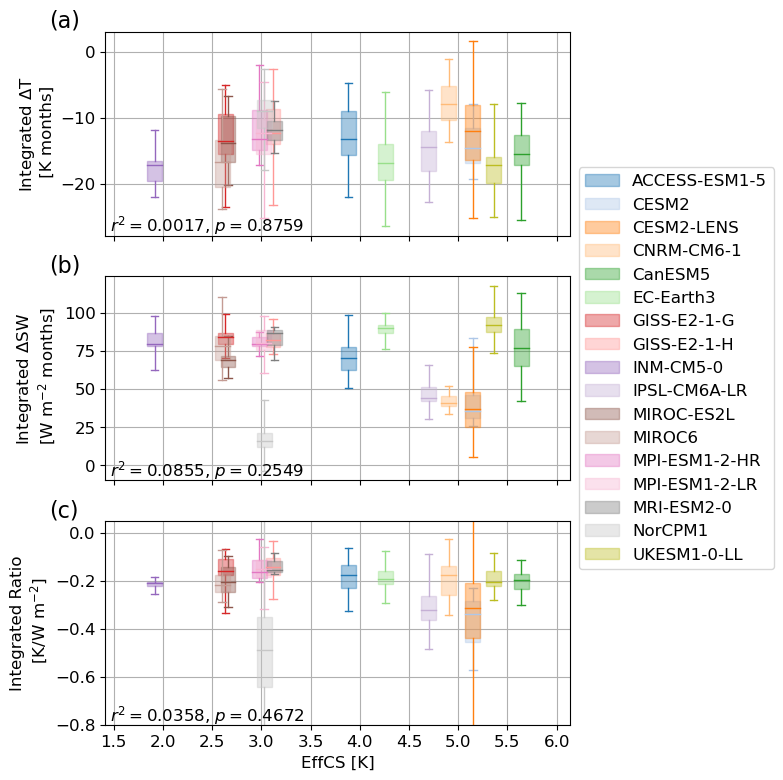

In [16]:
elements = []
labels = []

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 9))
for n, name in enumerate(sorted(list(model_dict.keys()))):
    print(name)

    ratio = int_dict[name]["temp"].data/int_dict[name]["sw"].data
    make_boxplot(ax1, n, name, int_dict[name]["temp"].data, ecs_dict, [], [])
    make_boxplot(ax2, n, name, int_dict[name]["sw"].data, ecs_dict, [], [])
    make_boxplot(ax3, n, name, ratio, ecs_dict, elements, labels)
    
ax1.annotate(f"$r^2=${r2_t:5.4f}, $p=${p_t:5.4f}",
             xy=(0.01, 0.02),
             xycoords="axes fraction",
             fontsize=12)

ax2.annotate(f"$r^2=${r2_sw:5.4f}, $p=${p_sw:5.4f}",
             xy=(0.01, 0.02),
             xycoords="axes fraction",
             fontsize=12)

ax3.annotate(f"$r^2=${r2_r:5.4f}, $p=${p_r:5.4f}",
             xy=(0.01, 0.02),
             xycoords="axes fraction",
             fontsize=12)
    
ax3.set_ylim(-0.5, 0.5)
ax1.set_xticks(np.arange(1.5, 6.01, 0.5))
ax2.set_xticks(np.arange(1.5, 6.01, 0.5))
ax3.set_xticks(np.arange(1.5, 6.01, 0.5))
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels(np.arange(1.5, 6.01, 0.5))
ax1.grid()
ax2.grid()
ax3.grid()

plt.legend([element["boxes"][0] for element in elements], 
           [labels[idx] for idx,_ in enumerate(sorted(list(model_dict.keys())))],
           loc='center left',
           bbox_to_anchor=(1, 1.75))

ax1.set_ylabel("Integrated $\Delta$T\n [K months]")
ax2.set_ylabel("Integrated $\Delta$SW\n [W m$^{-2}$ months]")
ax3.set_ylabel("Integrated Ratio\n [K/W m$^{-2}$]")
ax3.set_xlabel("EffCS [K]")
ax3.set_ylim(-0.8, 0.05)

ax1.annotate("(a)", xy=(-0.12, 1.02), xycoords="axes fraction", fontsize=16)
ax2.annotate("(b)", xy=(-0.12, 1.02), xycoords="axes fraction", fontsize=16)
ax3.annotate("(c)", xy=(-0.12, 1.02), xycoords="axes fraction", fontsize=16)

fig.savefig("../figures/reflectedsw_relationships_combined.png",
            bbox_inches="tight",
            dpi=150)

### Plot with axes flipped

In [17]:
def make_boxplot_vertical(axs,
                          n,
                          name,
                          data,
                          ecs_dict,
                          elements,
                          labels):
    
    b = axs.boxplot(data,
                vert=False,
                positions=[ecs_dict[name]],
                whis=(0, 100),
                labels=[name],
                patch_artist=True,
                boxprops={"facecolor": colors[n], "alpha": 0.4, "color": colors[n]},
                medianprops={"color": colors[n]},
                whiskerprops={"color": colors[n]},
                capprops={"color": colors[n]})
    elements.append(b)
    labels.append(name)
    
    return elements, labels

In [18]:
tvolc_sw = erbe_sw_anom.time.sel(time="1991-06").data[0]
tvolc_ts = hadcrut_ts_anom.time.sel(time="1991-06").data[0]

volc_index_sw = int(np.argwhere(erbe_sw_anom.time.data==tvolc_sw))
volc_index_ts = int(np.argwhere(hadcrut_ts_anom.time.data==tvolc_ts))

volc_index_ts

65

In [19]:
obssw = erbe_sw_anom.sel(time=slice("1991-06", "1996-05")).sum("time")
obst = hadcrut_ts_anom.sel(time=slice("1991-06", "1993-05")).sum("time")


obsratio = obst/obssw

In [20]:
swlist = []
tslist = []

for n in range(18, 25):

    for m in range(48, 73):

        sw = erbe_sw_anom.isel(time=slice(volc_index_sw, volc_index_sw+n)).sum("time").data
        ts = hadcrut_ts_anom.isel(time=slice(volc_index_ts, volc_index_ts+m)).sum("time").data

        swlist.append(sw)
        tslist.append(ts)
        
ratiolist = np.array(tslist) / np.array(swlist)

minsw = min(swlist)
maxsw = max(swlist)

mints = min(tslist)
maxts = max(tslist)

minratio = np.min(ratiolist)
maxratio = np.max(ratiolist)

print(f"Min SW anomaly: {minsw}")
print(f"Max SW anomaly: {maxsw}")

print(f"Min Ts anomaly: {mints}")
print(f"Max Ts anomaly: {maxts}")

print(f"Min ratio: {minratio}")
print(f"Max ratio: {maxratio}")

Min SW anomaly: 75.8273710434176
Max SW anomaly: 80.66915884123256
Min Ts anomaly: -7.170766363057867
Max Ts anomaly: -5.041722604414011
Min ratio: -0.09456699163356191
Max ratio: -0.06249876256100277


In [21]:
import pickle as pkl

with open("integrate_T_twolyr_result.pkl", "rb") as f:
    Tfit = pkl.load(f)
    
with open("integrate_sw_twolyr_result.pkl", "rb") as f:
    swfit = pkl.load(f)
    
with open("integrate_ratio_twolyr_result.pkl", "rb") as f:
    ratiofit = pkl.load(f)
    
x = np.arange(1, 7, 0.01)

y_T = Tfit["slope"]*x + Tfit["intcpt"]

y_sw = swfit["slope"]*x + swfit["intcpt"]

y_ratio = -(ratiofit["slope"]*x + ratiofit["intcpt"])

ACCESS-ESM1-5
CESM2
CESM2-LENS
CNRM-CM6-1
CanESM5
EC-Earth3
GISS-E2-1-G
GISS-E2-1-H
INM-CM5-0
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NorCPM1
UKESM1-0-LL


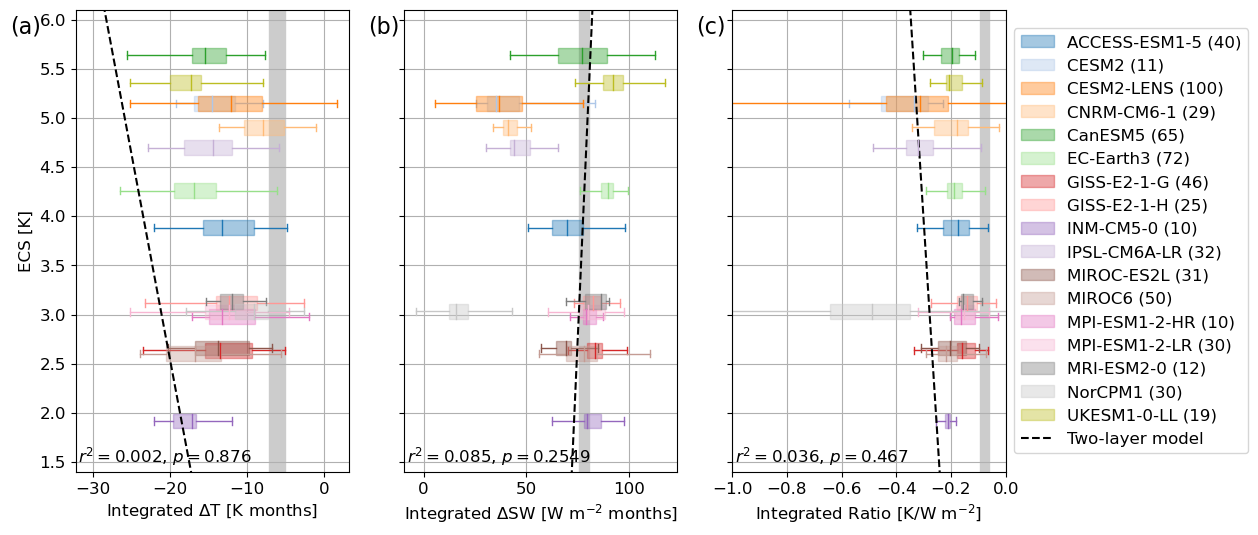

In [22]:
elements = []
labels = []

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6), sharey=True)
for n, name in enumerate(sorted(list(model_dict.keys()))):
    print(name)

    ratio = int_dict[name]["temp"].data/int_dict[name]["sw"].data
    make_boxplot_vertical(ax1, n, name, int_dict[name]["temp"].data, ecs_dict, [], [])
    make_boxplot_vertical(ax2, n, name, int_dict[name]["sw"].data, ecs_dict, [], [])
    make_boxplot_vertical(ax3, n, name, ratio, ecs_dict, elements, labels)
    
t1 = ax1.plot(y_T, x, "k--", label="Two-layer model")
t2 = ax2.plot(-y_sw, x, "k--", label="Two-layer model")
t3 = ax3.plot(-y_ratio, x, "k--", label="Two-layer model")


ax1.fill_between([mints, maxts], [1, 1], [7, 7], color="0.8")
ax2.fill_between([minsw, maxsw], [1, 1], [7, 7], color="0.8")
ax3.fill_between([minratio, maxratio], [1, 1], [7, 7], color="0.8")

ax1.annotate(f"$r^2=${r2_t:5.3f}, $p=${p_t:5.3f}",
             xy=(0.01, 0.02),
             xycoords="axes fraction",
             fontsize=12)

ax2.annotate(f"$r^2=${r2_sw:5.3f}, $p=${p_sw:5.4f}",
             xy=(0.01, 0.02),
             xycoords="axes fraction",
             fontsize=12)

ax3.annotate(f"$r^2=${r2_r:5.3f}, $p=${p_r:5.3f}",
             xy=(0.01, 0.02),
             xycoords="axes fraction",
             fontsize=12)

ax1.set_ylim(1.4, 6.1)
ax2.set_ylim(1.4, 6.1)
ax3.set_ylim(1.4, 6.1)

ax3.set_xlim(-0.5, 0.5)
ax1.set_yticks(np.arange(1.5, 6.01, 0.5))
ax2.set_yticks(np.arange(1.5, 6.01, 0.5))
ax3.set_yticks(np.arange(1.5, 6.01, 0.5))
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax1.set_yticklabels(np.arange(1.5, 6.01, 0.5))
ax2.set_yticklabels(np.arange(1.5, 6.01, 0.5))
ax3.set_yticklabels(np.arange(1.5, 6.01, 0.5))
ax1.grid()
ax2.grid()
ax3.grid()

handles = [element["boxes"][0] for element in elements]
handles.append(t1[0])

names = sorted(list(model_dict.keys()))
namelist = [f"{name} ({int_dict[name]['temp'].ensmem.size})" for name in names]
namelist.append("Two-layer model")

plt.legend(handles,
           namelist,
           loc='center left',
           bbox_to_anchor=(1, 0.5))

ax1.set_xlabel("Integrated $\Delta$T [K months]")
ax2.set_xlabel("Integrated $\Delta$SW [W m$^{-2}$ months]")
ax3.set_xlabel("Integrated Ratio [K/W m$^{-2}$]")
ax1.set_ylabel("ECS [K]")
ax3.set_xlim(-1, 0)

ax1.annotate("(a)", xy=(-0.24, 0.95), xycoords="axes fraction", fontsize=16)
ax2.annotate("(b)", xy=(-0.13, 0.95), xycoords="axes fraction", fontsize=16)
ax3.annotate("(c)", xy=(-0.13, 0.95), xycoords="axes fraction", fontsize=16)

fig.savefig("../figures/reflectedsw_relationships_combined_flipped.png",
            bbox_inches="tight",
            dpi=150)

### Plot T and SW anomalies

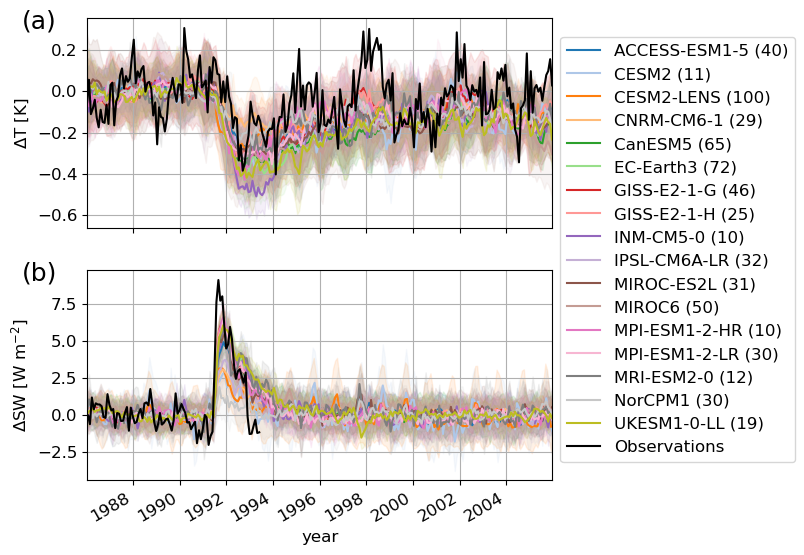

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

ax1.set_xlabel("")

for n, name in enumerate(sorted(list(model_dict.keys()))):
    std = data_dict[name]["tpert"].std("ensmem")
    mean = data_dict[name]["tpert"].mean("ensmem")
    ens = data_dict[name]["tpert"].ensmem.size
    t = data_dict[name]["tpert"].time.data
    ax1.fill_between(t, mean-std, mean+std, color=colors[n], alpha=0.1)
    mean.plot.line(x="time", color=colors[n], 
                   label=f"{name} ({ens})",
                   ax=ax1)
    
t1 = mean.time.sel(time="1986-01").data[0]
t2 = mean.time.sel(time="2005-12").data[0]

hadcrut_ts_anom.plot.line(x="time", color="k", ax=ax1)
ax1.grid()
ax1.set_ylabel("$\Delta$T [K]")
ax1.set_xlabel("")
ax1.set_title("")
ax1.set_xlim(t1, t2)

for n, name in enumerate(sorted(list(model_dict.keys()))):
    std = data_dict[name]["spert"].std("ensmem")
    mean = data_dict[name]["spert"].mean("ensmem")
    ens = data_dict[name]["tpert"].ensmem.size
    t = data_dict[name]["spert"].time.data
    ax2.fill_between(t, mean-std, mean+std, color=colors[n], alpha=0.1)
    mean.plot.line(x="time", color=colors[n], label=f"{name} ({ens})", ax=ax2)

erbe_sw_anom.plot.line(x="time", color="k", label="Observations", ax=ax2)
ax2.grid()
ax2.set_ylabel("$\Delta$SW [W m$^{-2}$]")
ax2.set_xlabel("year")
ax2.set_xlim(t1, t2)
ax2.legend(loc='center left', bbox_to_anchor=(1, 1.1))

ax1.annotate("(a)",
             xy=(-0.14, 0.95),
             xycoords="axes fraction",
             fontsize=18)

ax2.annotate("(b)",
             xy=(-0.14, 0.95),
             xycoords="axes fraction",
             fontsize=18)

fig.savefig("../figures/reflectedsw_anomalies_combined.png",
            bbox_inches="tight", dpi=150)

### Compute correlation between peak T and peak SW anomalies

r^2: 0.1222, p: 0.1690824673015757


Text(0.5, 0, 'Min T perturbation [K]')

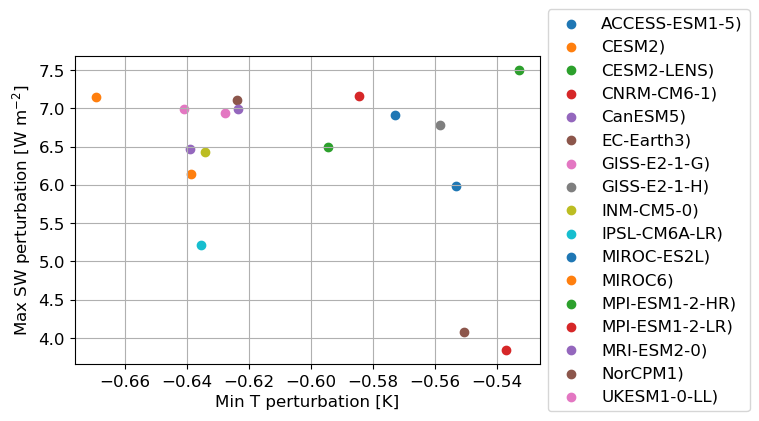

In [27]:
tmax_list = []
smax_list = []

for n, name in enumerate(sorted(list(model_dict.keys()))):
    smax = data_dict[name]["spert"].max("time").mean("ensmem")
    tmax = data_dict[name]["tpert"].min("time").mean("ensmem")
    
    tmax_list.append(tmax)
    smax_list.append(smax)
    
    
    plt.scatter(tmax, smax, label=f"{name})")
    
    
tmax_arr = np.array(tmax_list)
smax_arr = np.array(smax_list)

corr, p = pearsonr(tmax_arr, smax_arr)
print(f"r^2: {corr**2:5.4f}, p: {p}")

plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

plt.grid()
plt.ylabel("Max SW perturbation [W m$^{-2}$]")
plt.xlabel("Min T perturbation [K]")